In [74]:
import math as m
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import pickle
import os
import warnings

In [3]:
class Archive:
    def __init__(self, size, D_min, D_sim):
        """
        Initialize the Archive object.

        Parameters:
        size (int): The maximum size of the archive.
        D_min (float): The minimum dissimilarity threshold for archive entries.
        D_sim (float): The similarity threshold for replacing similar entries.
        """
        self.archive = []
        self.size = size
        self.D_min = D_min
        self.D_sim = D_sim

    def add(self, coordinates, value):
        """
        Add a candidate to the archive.

        Parameters:
        candidate (tuple): A tuple containing the candidate coordinates and its fitness (coordinates, fitness).
        """
        candidate = (coordinates, value)
        dissimilarities = np.array([np.linalg.norm(candidate[0] - x[0]) for x in self.archive])
        archive_objectives = [x[1] for x in self.archive]

        if not self.archive or (len(self.archive) < self.size and np.all(dissimilarities > self.D_min)):
            # If the archive is empty or not full and candidate is dissimilar enough, add it
            self.archive.append(candidate)     
        elif len(self.archive) == self.size: # If the archive is full
            closest_entry_index = np.argmin(dissimilarities)
            closest_dissimilarity = dissimilarities[closest_entry_index]

            if closest_dissimilarity > self.D_sim and candidate[1] < archive_objectives[closest_entry_index]:
                # Replace the closest less fit similar entry
                self.archive[closest_entry_index] = candidate
            elif np.all(dissimilarities > self.D_min) and candidate[1] < max(archive_objectives):
                # Replace the least fit entry if candidate is dissimilar enough and better than the least fit entry
                self.archive[-1] = candidate
        
        self.archive.sort(key=lambda x: x[1]) # Sort the archive based on fitness

    def get_archive(self):
        """
        Get the current state of the archive.

        Returns:
        list: The sorted list of archive entries.
        """
        return self.archive
    
    def values(self):
        """
        Get values of all points in the archive list.

        Returns:
        list: A list of values of all points in the archive list.
        """
        return np.array([point[1] for point in self.archive])

    def coordinates(self):
        """
        Get coordinates of all points in the archive list.

        Returns:
        list: A list of coordinates of all points in the archive list.
        """
        return np.array([point[0] for point in self.archive])

In [78]:
elements= 10
u0= 1.5
max_twist = np.pi/8
min_twist = np.pi/150
TSR_max = 10
TSR_min = 4
Number_Blades = 3
starting_radius = 0.05
tip_constraint = 1.0
swept_radius = 1.0
aerofoils = ['naca4412', 'naca4415', 'naca23012']
blade_length = swept_radius * (1 - starting_radius - (1 - tip_constraint))
relaxation_factor = 0.6 # Convergence speed for BEM method 
alpha_max = 21 # maximum allowed angle of attack

# Import XFOIL Interpolator MAPS

In [5]:
cl_interpolators_path = 'CL_interpolators.pkl'
cd_interpolators_path = 'CD_interpolators.pkl'

# Load CL_interpolators
try:
    with open(cl_interpolators_path, 'rb') as f:
        CL_interpolators = pickle.load(f)
    print('Successfully loaded CL_interpolators')
except Exception as e:
    print(f'Failed to load CL_interpolators: {e}')
 
# Load CD_interpolators
try:
    with open(cd_interpolators_path, 'rb') as f:
        CD_interpolators = pickle.load(f)
    print('Successfully loaded CD_interpolators')
except Exception as e:
    print(f'Failed to load CD_interpolators: {e}')

def check_bounds(Re, alpha, aerofoil):
    # Check if the values are within bounds
    if Re < CL_interpolators[aerofoil].grid[0][0]:
        #print('Re smaller than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][0]
        
    elif Re > CL_interpolators[aerofoil].grid[0][-1]:
        #print('Re higher than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][-1]
        
    if alpha < CD_interpolators[aerofoil].grid[1][0]:
        #print('Alpha smaller than grid', alpha )
        alpha = CD_interpolators[aerofoil].grid[1][0]
        
    elif alpha > CD_interpolators[aerofoil].grid[1][-1]:
        #print('Alpha higher than grid', alpha)
        alpha = CD_interpolators[aerofoil].grid[1][-1]
    return (Re, alpha)

def check_bounds_debug(Re, alpha, aerofoil):
    # Check if the values are within bounds
    if Re < CL_interpolators[aerofoil].grid[0][0]:
        print('Re smaller than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][0]
        
    elif Re > CL_interpolators[aerofoil].grid[0][-1]:
        print('Re higher than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][-1]
        
    if alpha < CD_interpolators[aerofoil].grid[1][0]:
        print('Alpha smaller than grid', alpha )
        alpha = CD_interpolators[aerofoil].grid[1][0]
        
    elif alpha > CD_interpolators[aerofoil].grid[1][-1]:
        print('Alpha higher than grid', alpha)
        alpha = CD_interpolators[aerofoil].grid[1][-1]
        
    return (Re, alpha)


Successfully loaded CL_interpolators
Successfully loaded CD_interpolators


In [6]:
CD_interpolators[aerofoils[0]].grid[1][-1]

19.0

# BEM Method and Power Coefficient

### Taper function

In [7]:
def taper_function(r, c0, a1, a2, a3, l_blade):
    """
    Quadratic polynomial taper function.
    
    Parameters:
    r (array-like): Radial positions.
    a0 (float): Root chord length
    a1 (float): Coefficient for r^1 
    a2 (float): Coefficient for r^2 

    Returns:
    array-like: Taper values at each radial position.
    """
    return c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))

## BEM debugging

In [82]:
def BEM_debug(x, aerofoil, n_blades=3, u0=u0, tip_constraint=tip_constraint, rhub=starting_radius, r_total=swept_radius, n=elements, relax=relaxation_factor, alpha_max=alpha_max):
    """ BEM method for the entire blade 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    # Constants
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
    twirl = twirl0 - (r - rhub) / l_blade * twist # twirl of each cord element stored in array
    area = sum(dr * c) # area of the blade
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        print('------------------------------------------')
        print(f'Element {i}')
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 100: 
                print('Not converged')
                return None
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            alpha = np.degrees(phi) - twirl[i] # local angle of attack in degrees
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha, aerofoil) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = CL_interpolators[aerofoil](checked_values) # lift coefficeint
            Cd = CD_interpolators[aerofoil](checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    print(f'Number of iterations: {counter}')
                    print(f'Angle of attack: {alpha}')
                    print(f'Reynolds: {Re}')
                    print(f'CL: {Cl}')
                    print(f'CD: {Cd}')
                    print(f'a: {a[i]}')
                    print(f'Chord length {c[i]}')
                    print(f'Twirl {twirl[i]}')
                    if a[i] < 0:
                        warnings.warn(f'Negative induction factor at element {i}: a = {a[i]}', RuntimeWarning)
                        a[i] = 0  # Set a to zero to maintain physical bounds
                    break
            counter += 1
        # if alpha > alpha_max or alpha < 0:
        #     print('Alpha too high')
        #     return None
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*r*dr
    for i in range(n):
        print(f'dQ{i}: {dQ[i]}')
    # if np.any(dQ < 0):
    #     print('Negative dQ values')
    #     return None
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, omega, area)

## BEM w/o printing

In [121]:
def BEM(x, aerofoil, u0=u0, n_blades=3, tip_constraint=tip_constraint, rhub=starting_radius, r_total=swept_radius, n=elements, relax=relaxation_factor, alpha_max=alpha_max):
    """ BEM method for the entire blade 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    # Constants
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
    twirl = twirl0 - (r - rhub) / l_blade * twist # twirl of each cord element stored in array
    area = sum(dr * c) # area of the blade
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 100: 
                return None
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            alpha = np.degrees(phi) - twirl[i] # local angle of attack in degrees
            if counter < 5:
                pass
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha, aerofoil) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = CL_interpolators[aerofoil](checked_values) # lift coefficeint
            Cd = CD_interpolators[aerofoil](checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    if a[i] < 0:
                        # warnings.warn(f'Negative induction factor at element {i}: a = {a[i]}', RuntimeWarning)
                        a[i] = 0  # Set a to zero to maintain physical bounds
                    break
            counter += 1
        # if alpha > alpha_max or alpha < 0:
        #     return None
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*r*dr
    # if np.any(dQ < 0):
    #     return None
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, omega, area)

In [134]:
def power_coefficent(torque, omega, u0=u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (float): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    power = torque*omega
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    #print(cp)
    if cp >= 0 and cp <= 16/27:
        return cp         
    else:
        return -np.inf

def coefficent(x, aerofoil, u0=u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (float): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    bem = BEM(x, aerofoil, u0=u0)
    power = bem[3]*bem[4]
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    #print(cp)
    if cp <= 16/27:
        return cp         
    else:
        return -np.inf

def power_drawn(torque, omega, u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (array): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (array or float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    power = torque*omega
    #print('power',power)
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    #print('cp',cp)
    if np.all(cp <= 16/27):
        #print('All cp below 16/27')
        return power         
    else:
        return -np.inf


# Objective Function & Constraints

## Objective function

In [137]:
def objective_function(x, aerofoil):
    solution = BEM(x, aerofoil)
    if solution is None:
        return np.inf
    else:
        cp = power_coefficent(solution[3], solution[4])
        area = solution[5]
    return -cp/area

def objective_function_debug(x, aerofoil):
    solution = BEM_debug(x, aerofoil)
    if solution is None:
        return np.inf
    else:
        cp = power_coefficent(solution[3], solution[4])
        area = solution[5]
    return -cp/area

def objective_wind_speeds(x, wind_speeds, aerofoil):
    solutions = [] # empty array to store the soiltuons in
    for i, wind_speed in enumerate(wind_speeds): # Conduct BEM for the different wind speeds
        bem = BEM(x, aerofoil, u0=wind_speed) 
        solutions.append(bem)
    if any(solution is None for solution in solutions): # if one solutions is invalid, everything is discarded
        return np.inf
    else:
        area = solutions[0][5] # area of the blade
        torques = np.array([solution[3] for solution in solutions]) # array that contains the torques at different wind speeds
        omegas = np.array([solution[4] for solution in solutions]) # array that contains teh omagas at different wind speeds
        power = power_drawn(torques, omegas, wind_speeds) # array that contains the power drawn at different wind speeds
        for i in range(len(power)):
            if power[i] < 0: 
                power[i] *= 100 # penalize negative values more 
        sum_ratio = np.sum(power / area)
        return - sum_ratio

def objective_wind_speeds_debug(x, wind_speeds, aerofoil):
    solutions = [] # empty array to store the soiltuons in
    for i, wind_speed in enumerate(wind_speeds): # Conduct BEM for the different wind speeds
        print('=============================================')
        print('Wind speed', wind_speed)
        bem = BEM_debug(x, aerofoil, u0=wind_speed) 
        solutions.append(bem)
    none_indices = [i for i, solution in enumerate(solutions) if solution is None] # Check if any solution is None and collect indices
    if none_indices:  # If there are any None values
        print("Indices with None:", none_indices)
        return np.inf
    else:
        print('ALL SOLUTIONS ARE VALID')
        area = solutions[0][5] # area of the blade
        torques = np.array([solution[3] for solution in solutions]) # array that contains the torques at different wind speeds
        omegas = np.array([solution[4] for solution in solutions]) # array that contains teh omagas at different wind speeds
        power = power_drawn(torques, omegas, wind_speeds) # array that contains the power drawn at different wind speeds
        sum_ratio = np.sum(power / area)
        return - sum_ratio

## Constraint function

In [89]:
cmin = 0.07 * swept_radius # minimum allowed chord length
c0min = 1/10 * swept_radius # minimum root chord length
c0max = 0.25 * swept_radius  # maximum root chord length
twirl0min = 5 # minimum root twirl
twirl0max = 45 # maximum root twirl
twistmin= 0 # minimum twist
tsrmin = 4 # minimum tip-speed ratio
tsrmax = 15 # maximum tip-speed ratio
def tapermin(c0, cmin):
    return cmin / c0

In [14]:
def constraint_function(x, cmin=cmin, c0min=c0min, c0max=c0max, twistmin=twistmin, tsrmin=tsrmin, tsrmax=tsrmax, twirl0max=twirl0max, twirl0min=twirl0min):
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    c1 = max(0, c0min - c0) # minimum root chord length
    c2 = max(0, c0 - c0max) # maximum root chord length
    c3 = max(0, cmin - taper_function(blade_length, c0, a1, a2, a3, blade_length)) # minimum chord length at tip of the blade (0.95 of length) 
    c4 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at tip of the blade (0.95 of length --> not longer than c0
    c5 = max(0, taper_function(0.6*blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at r = 0.6R --> not greater than c0
    c6 = max(0, tsrmin - tsr) # minimum tip-speed ratio
    c7 = max(0, tsr - tsrmax) # maximum tip-speed ratio
    c8 = max(0, twistmin - twist) # minimum twist of entire blade
    c9 = max(0, twist - twirl0)  # maximum twist of entire blade
    c10 = max(0, twirl0min - twirl0) # minimum root twirl
    c11 = max(0, twirl0 - twirl0max) # maximum root twirl
    
    return 100 * (c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 + c9 + c10 + c11)

def constraint_function_debug(x, cmin=cmin, c0min=c0min, c0max=c0max, twistmin=twistmin, tsrmin=tsrmin, tsrmax=tsrmax, twirl0max=twirl0max, twirl0min=twirl0min):
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    c1 = max(0, c0min - c0) # minimum root chord length
    c2 = max(0, c0 - c0max) # maximum root chord length
    c3 = max(0, cmin - taper_function(blade_length, c0, a1, a2, a3, blade_length)) # minimum chord length at tip of the blade (0.95 of length) 
    c4 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at tip of the blade (0.95 of length --> not longer than c0
    c5 = max(0, taper_function(0.6*blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at r = 0.6R --> not greater than c0
    c6 = max(0, tsrmin - tsr) # minimum tip-speed ratio
    c7 = max(0, tsr - tsrmax) # maximum tip-speed ratio
    c8 = max(0, twistmin - twist) # minimum twist of entire blade
    c9 = max(0, twist - twirl0)  # maximum twist of entire blade
    c10 = max(0, twirl0min - twirl0) # minimum root twirl
    c11 = max(0, twirl0 - twirl0max) # maximum root twirl

    for i in range(1, 12):
        print(f'c{i}: {locals()[f"c{i}"]}')

    return 100 * (c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 + c9 + c10 + c11)

def generate_random_x(aerofoil):
    # generates a solution within the constraints that is feasible
    counter = 1
    while True:
        c0 = np.random.uniform(c0min, c0max)
        twirl0 = np.random.uniform(twirl0min, twirl0max)
        twist = np.random.uniform(twistmin, twirl0)
        a0 = np.random.uniform(tapermin(c0, cmin), 1)
        tsr = np.random.uniform(tsrmin, tsrmax)
        a1 = a2 = 1
        candidate = np.array([c0, twirl0, twist, tsr, a0, a1, a2])
        if constraint_function(candidate) == 0:
            if -1 < objective_function(candidate, aerofoil) < 0:
                return candidate
        counter += 1

def generate_random_x_debug(aerofoil):
    # generates a solution within the constraints that is feasible
    counter = 1
    while True:
        print('=====================================================')
        print(f'Candidate {counter}')
        c0 = np.random.uniform(c0min, c0max)
        twirl0 = np.random.uniform(twirl0min, twirl0max)
        twist = np.random.uniform(twistmin, twirl0)
        a0 = np.random.uniform(tapermin(c0, cmin), 1)
        tsr = np.random.uniform(tsrmin, tsrmax)
        a1 = a2 = 1
        candidate = np.array([c0, twirl0, twist, tsr, a0, a1, a2])
        if constraint_function_debug(candidate) == 0:
            if -16/27 < objective_function_debug(candidate, aerofoil) < 0:
                print('Candidate found', objective_function_debug(candidate, aerofoil))
                return candidate
        counter += 1
        if counter == 50:
            pass
            #return None

In [117]:
wind_speeds = np.linspace(15,150,10)/100
#np.random.seed(1)
x = generate_random_x(aerofoils[1])
objective_wind_speeds_debug(x, wind_speeds, aerofoils[1])

Wind speed 0.15
------------------------------------------
Element 0
Number of iterations: 8
Angle of attack: 27.182220526681625
Reynolds: 1998.4267617570763
CL: 0.8055
CD: 0.24062
a: 0.2383319933598871
Chord length 0.19427793361025275
Twirl 20.488745629553407
------------------------------------------
Element 1
Number of iterations: 6
Angle of attack: 16.219092271182717
Reynolds: 2707.5338291361054
CL: 0.7009494565120069
CD: 0.20352848445534585
a: 0.20458769778103852
Chord length 0.1934011334647683
Twirl 18.352649230307506
------------------------------------------
Element 2
Number of iterations: 5
Angle of attack: 10.725131894067513
Reynolds: 3563.0224119447716
CL: 0.48122937388277365
CD: 0.14016578554739656
a: 0.1603990242071046
Chord length 0.19252433331928387
Twirl 16.216552831061605
------------------------------------------
Element 3
Number of iterations: 5
Angle of attack: 7.6905956408437
Reynolds: 4462.808615705747
CL: 0.3421567321628122
CD: 0.11195081084107479
a: 0.1348135375

-12.536425291836471

In [16]:
# x = np.array([0.24828454, 19.02815265, 13.28231143,  4.00269716, 0.90170453, 1, 1])
# x = np.array([0.24957787, 31.96529959, 31.79566647, 5.10131531, 0.97641639, 1.02030535, 1])
x = np.array([0.24957787, 31.96529959, 31.79566647, 5.10131531, 0.97641639, 1, 1])
result = 0.25715790365903507
objective_function(x, aerofoils[1])

inf

# Evolution Strategies

## Single wind speed optimisation

In [ ]:
# Problem definition
n = 7  # Dimensions
aerofoil = aerofoils[1]        
# Initiate archive
archive_ = Archive(size=25, D_min=0.1, D_sim=0.01)
# Exogeneous strategy parameters
mu = 10  # Number of parents
n_mutations = int(50)  # Offspring per parent
lambda_ = mu * n_mutations  # Number of offspring
sigma = 1 # initial step size
stopping_criterion = 1e-4  # difference between the mean and the fittest individual
penalty = 1.0  # Initial multiplier of penalty function

# Exogeneous mutation parameters
beta = 0.0873
tau = 1 / np.sqrt(2 * np.sqrt(n))
tau_prime = 1 / np.sqrt(2 * n)
C = np.eye(n)  # Initial covariance matrix, identity matrix so first mutation isn't biased
detC = 1
alpha_ij = np.zeros((n, n))  # Empty matrix to store the rotation angles

# Generate initial population
parents = np.array([generate_random_x(aerofoil) for _ in range(mu)])  # Random population within 0 <= x <= 10
print('initial parents', parents)
parents_fitness = np.array([objective_function(p, aerofoil) + constraint_function(p) for p in parents])
print('initial fitness', parents_fitness)
w = np.ones(mu) / mu
m = np.mean(parents, axis=0)
offspring = np.empty((lambda_, n))  # empty array for offspring

# -------------------- Generation Loop --------------------------------
f_evals = 0
generation = 1 
while f_evals <= 10000 - lambda_ and generation <= 30:
    print(' ---------------------------------------------------')
    print('GENERATION', generation)
    # -------------------- Recombination and mutation of parents -------------------------------- 
    if generation == 1:
        # Define the increment direction array
        increment_direction = np.array([0.05, 5, 3, 0.5, 0.1, 0.1, 0.05])
        for i in range(lambda_):  # Iterate through lambda_ individuals  
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            step_size = np.random.uniform(-1, 1, increment_direction.shape) # Generate random values in the range [-1, 1] for each element
            n_ = step_size * increment_direction # Scale the random values by the increment_direction values
            offspring[i] = z + sigma * n_  # Generate offspring variables
    else:
        for i in range(lambda_):  # Iterate through lambda_ individuals   
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            n_ = np.random.multivariate_normal(np.zeros(n), C)  # Mutation vector from mutated covariance matrix
            offspring[i] = z + sigma * n_  # Generate offspring variables
    population = np.vstack((parents, offspring))  # Combine parents and offspring to form new population
    #population =  offspring  # Combine parents and offspring to form new population

    # -------------------- Elitist selection --------------------------------
    penalty = max(1, np.exp(np.log(1 / detC)))
    osfitness = np.array([objective_function(offspring[i], aerofoil) + penalty * constraint_function(offspring[i]) for i in range(lambda_)])  # Constraint included in the fitness as penalty function
    # print(' ---------------------------------------------------')
    # print(' ---------------------------------------------------')
    # print('OS fitness:', np.sum(osfitness < 0))
    # print(' ---------------------------------------------------')
    popfitness = np.hstack((parents_fitness, osfitness))  # Combine the fitness of parents and offspring
    #popfitness = osfitness # Combine the fitness of parents and offspring
    popindex = np.argsort(popfitness)  # Sort indices of the population fitness in ascending order
    parents, parents_fitness = population[popindex[:mu]], popfitness[popindex[:mu]]  # Select the mu fittest individuals as parents
    best_parent, best_fitness = parents[0], parents_fitness[0]  # Variables and objective of the fittest individual
    # print('best_parent', best_parent)
    # print('best cp', best_fitness)
    # print('parents', parents)
    # print(' ---------------------------------------------------')
    formatted_fitness = [f'{fitness:.10f}' for fitness in parents_fitness]
    print('parents fitness:', formatted_fitness)
    f_evals += lambda_

    # -------------------- Convergence criterion --------------------------------
    if abs(best_fitness - np.max(popfitness)) <= stopping_criterion:
        print('Algorithm converged')
        break

    # -------------------- Mutation of strategy parameters --------------------------------
    # Computation of covariance matrix 
    w = np.where(parents_fitness < 0, parents_fitness, 0) # Set positive fitness values to zero and keep negative values
    if np.sum(w) != 0:  # Avoid division by zero 
        w = w / np.sum(w) # Normalize the weights for negative values only
    else: # Handle edge case where all values are non-negative
        w = np.ones_like(parents_fitness) / len(parents_fitness)  
    # w = (parents_fitness / np.sum(parents_fitness)).ravel()  # Weight of the parents in current generation
    # if np.any(w < 0):
    #     w = np.ones(mu)/ mu
    std = parents - m  # Standard deviations of individual in a mu x n matrix
    m = np.mean(parents, axis=0)  # Update the mean of the variables from previous to current generation
    C = std.T * w @ std  # Weighted covariance matrix of new generation
    detC = np.linalg.det(C)

    # Mutation strengths
    N0 = np.random.normal(0, 1)  # Scalar for global mutation strength
    Ni = np.random.normal(0, 1, size=n)  # Vector for individual mutation strengths
    Nij = np.triu(np.random.normal(0, 1, size=(n, n)), 1)  
    
    # Computation of rotation angle 
    vij = C.diagonal()[:, None] - C.diagonal()[None, :]
    vij[vij == 0] = 1
    aij = 0.5 * np.arctan(2 * C / vij)

    # Mutation of strategy parameters
    var = np.diag(C) * np.exp(tau_prime * N0 + tau * Ni) ** 2  # Variances
    aij = aij + beta * Nij  # Rotation angles
    aij = np.triu(aij) + np.triu(aij).T  # Enforce symmetry

    # Computation of mutated covariance matrix 
    vij = var[:, None] - var[None, :]  # Denominator for the computation of the covariances
    vij[vij == 0] = 1  # Avoid division by zero in the diagonal
    C = np.tan(2 * aij) * vij / 2  # Off diagonal elements are the mutated covariances --> computed from mutated rotation angle and variances
    np.fill_diagonal(C, var)  # Diagonal elements are the mutated variances

    # Adjustment of mutated covariance matrix if not positive semi-definite
    eigenvalues, eigenvectors = np.linalg.eigh(C)  # Computation of eigenvalues and eigenvectors
    if not np.all(eigenvalues > 0):
        print('Negative eigenvalues')
        eigenvalues = np.maximum(eigenvalues, 0)  # Adjustment of eigenvalues to ensure they are all non-negative
        C = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T  # Reconstruction of positive semi-definite mutated covariance matrix 

    generation += 1  # Increase generation counter

    # -------------------- Archive --------------------------------
    archive_candidate = (best_parent, best_fitness)
    #Archive.add(archive_candidate)

    print(best_parent, best_fitness)
print(f'Best parent {best_parent}')
print(f'Best fitness {best_fitness}')

## Multi windspeed optimisation

In [126]:
# Problem definition
n = 7  # Dimensions
aerofoil = aerofoils[1] 
wind_speeds = np.linspace(15, 150, 10) / 100    
# Initiate archive
archive_ = Archive(size=25, D_min=0.1, D_sim=0.01)
# Exogeneous strategy parameters
mu = 10  # Number of parents
n_mutations = int(50)  # Offspring per parent
lambda_ = mu * n_mutations  # Number of offspring
sigma = 1 # initial step size
stopping_criterion = 1e-4  # difference between the mean and the fittest individual
penalty = 1.0  # Initial multiplier of penalty function

# Exogeneous mutation parameters
beta = 0.0873
tau = 1 / np.sqrt(2 * np.sqrt(n))
tau_prime = 1 / np.sqrt(2 * n)
C = np.eye(n)  # Initial covariance matrix, identity matrix so first mutation isn't biased
detC = 1
alpha_ij = np.zeros((n, n))  # Empty matrix to store the rotation angles

# Define function for covariance matrix maniopulation
def ensure_symmetric(matrix):
    return (matrix + matrix.T) / 2
def regularize_matrix(matrix, epsilon=1e-10):
    return matrix + np.eye(matrix.shape[0]) * epsilon
def make_positive_semidefinite(matrix, epsilon=1e-10, max_attempts=10):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    for attempt in range(max_attempts):
        if np.all(eigenvalues > 0):
            return matrix  # The matrix is already positive semi-definite
        eigenvalues[eigenvalues < 0] = 0  # Set negative eigenvalues to zero
        matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        # Regularize a bit more if needed
        matrix += np.eye(matrix.shape[0]) * epsilon * (attempt + 1)
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    raise RuntimeError("Failed to make the matrix positive semi-definite after several attempts.")

# Generate initial population
parents = np.array([generate_random_x(aerofoil) for _ in range(mu)])  # Random population within 0 <= x <= 10
print('initial parents', parents)
parents_fitness = np.array([objective_wind_speeds(p, wind_speeds, aerofoil) + constraint_function(p) for p in parents])
print('initial fitness', parents_fitness)
w = np.ones(mu) / mu
m = np.mean(parents, axis=0)
offspring = np.empty((lambda_, n))  # empty array for offspring

# -------------------- Generation Loop --------------------------------
f_evals = 0
generation = 1 
while f_evals <= 10000 - lambda_ and generation <= 20:
    print(' ---------------------------------------------------')
    print('GENERATION', generation)
    # -------------------- Recombination and mutation of parents -------------------------------- 
    if generation == 1: 
        increment_direction = np.array([0.05, 5, 3, 0.5, 0.1, 0.1, 0.05]) # Define the increment direction array
        for i in range(lambda_):  # Iterate through lambda_ individuals  
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            step_size = np.random.uniform(-1, 1, increment_direction.shape) # Generate random values in the range [-1, 1] for each element
            n_ = step_size * increment_direction # Scale the random values by the increment_direction values
            offspring[i] = z + sigma * n_  # Generate offspring variables
    else:
        for i in range(lambda_):  # Iterate through lambda_ individuals   
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            n_ = np.random.multivariate_normal(np.zeros(n), C)  # Mutation vector from mutated covariance matrix
            offspring[i] = z + sigma * n_  # Generate offspring variables
    population = np.vstack((parents, offspring))  # Combine parents and offspring to form new population
    #population =  offspring  # Combine parents and offspring to form new population

    # -------------------- Elitist selection --------------------------------
    penalty = max(1, np.exp(np.log(1 / detC)))
    osfitness = np.array([objective_wind_speeds(offspring[i], wind_speeds, aerofoil) + penalty * constraint_function(offspring[i]) for i in range(lambda_)])  # Constraint included in the fitness as penalty function
    # print(' ---------------------------------------------------')
    # print(' ---------------------------------------------------')
    # print('OS fitness:', np.sum(osfitness < 0))
    # print(' ---------------------------------------------------')
    popfitness = np.hstack((parents_fitness, osfitness))  # Combine the fitness of parents and offspring
    #popfitness = osfitness # Combine the fitness of parents and offspring
    popindex = np.argsort(popfitness)  # Sort indices of the population fitness in ascending order
    parents, parents_fitness = population[popindex[:mu]], popfitness[popindex[:mu]]  # Select the mu fittest individuals as parents
    best_parent, best_fitness = parents[0], parents_fitness[0]  # Variables and objective of the fittest individual
    # print('best_parent', best_parent)
    # print('best cp', best_fitness)
    # print('parents', parents)
    # print(' ---------------------------------------------------')
    formatted_fitness = [f'{fitness:.10f}' for fitness in parents_fitness]
    print('parents fitness:', formatted_fitness)
    f_evals += lambda_

    # -------------------- Convergence criterion --------------------------------
    if abs(best_fitness - np.max(parents_fitness)) <= stopping_criterion:
        print('Algorithm converged')
        break

    # -------------------- Mutation of strategy parameters --------------------------------
    # Computation of covariance matrix 
    w = np.where(parents_fitness < 0, parents_fitness, 0) # Set positive fitness values to zero and keep negative values
    if np.sum(w) != 0:  # Avoid division by zero 
        w = w / np.sum(w) # Normalize the weights for negative values only
    else: # Handle edge case where all values are non-negative
        w = np.ones_like(parents_fitness) / len(parents_fitness)  
    # w = (parents_fitness / np.sum(parents_fitness)).ravel()  # Weight of the parents in current generation
    # if np.any(w < 0):
    #     w = np.ones(mu)/ mu
    std = parents - m  # Standard deviations of individual in a mu x n matrix
    m = np.mean(parents, axis=0)  # Update the mean of the variables from previous to current generation
    C = std.T * w @ std  # Weighted covariance matrix of new generation
    detC = np.linalg.det(C)

    # Mutation strengths
    N0 = np.random.normal(0, 1)  # Scalar for global mutation strength
    Ni = np.random.normal(0, 1, size=n)  # Vector for individual mutation strengths
    Nij = np.triu(np.random.normal(0, 1, size=(n, n)), 1)  
    
    # Computation of rotation angle 
    vij = C.diagonal()[:, None] - C.diagonal()[None, :]
    vij[vij == 0] = 1
    aij = 0.5 * np.arctan(2 * C / vij)

    # Mutation of strategy parameters
    var = np.diag(C) * np.exp(tau_prime * N0 + tau * Ni) ** 2  # Variances
    aij = aij + beta * Nij  # Rotation angles
    aij = np.triu(aij) + np.triu(aij).T  # Enforce symmetry

    # Computation of mutated covariance matrix 
    vij = var[:, None] - var[None, :]  # Denominator for the computation of the covariances
    vij[vij == 0] = 1  # Avoid division by zero in the diagonal
    C = np.tan(2 * aij) * vij / 2  # Off diagonal elements are the mutated covariances --> computed from mutated rotation angle and variances
    np.fill_diagonal(C, var)  # Diagonal elements are the mutated variances

    # Adjustment of mutated covariance matrix if not positive semi-definite
    C = ensure_symmetric(C) # Ensure the matrix is symmetric
    C = regularize_matrix(C) # Try regularizing the matrix
    try: # Attempt to compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(C)
    except np.linalg.LinAlgError:
        warnings.warn("Eigenvalues did not converge, attempting further adjustments.", RuntimeWarning)
        C = make_positive_semidefinite(C) # Try positive semi-definite
        try:
            eigenvalues, eigenvectors = np.linalg.eigh(C)
        except np.linalg.LinAlgError:
            raise RuntimeError("Eigenvalues did not converge after multiple adjustments.")

    generation += 1  # Increase generation counter

    # -------------------- Archive --------------------------------
    archive_candidate = (best_parent, best_fitness)
    #Archive.add(archive_candidate)

    print('best parent', best_parent)
print(f'Best parent {best_parent}')

initial parents [[ 0.22127068  9.2478791   1.76924703  6.84960142  0.97511244  1.
   1.        ]
 [ 0.18838728 28.08291913 25.98024953  5.9077255   0.43199617  1.
   1.        ]
 [ 0.15771477  5.28131811  1.58226661  6.8447226   0.8645477   1.
   1.        ]
 [ 0.10376685 23.47490948 20.57264023  4.5553022   0.91340562  1.
   1.        ]
 [ 0.12692126 26.44701397 18.15568913  4.61637769  0.72259536  1.
   1.        ]
 [ 0.23200306 19.57186311 10.67392224  5.23560879  0.4726449   1.
   1.        ]
 [ 0.11728755 14.0667134  11.53347557  7.3554053   0.83704147  1.
   1.        ]
 [ 0.19193738 16.74311226  8.20611399  5.65827449  0.39109965  1.
   1.        ]
 [ 0.19873123 20.5362905  17.58322541  7.10682735  0.88833457  1.
   1.        ]
 [ 0.13916846  9.88875823  4.09147403  7.92747431  0.63650147  1.
   1.        ]]
initial fitness [-7.58170154  3.14476229 -0.44222648 -6.67075173  2.769673   -6.28739349
  8.38497947  7.11199741  2.01151043 23.78502023]
 ---------------------------------

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_5855/2149476891.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle


parents fitness: ['-26.1818671783', '-25.2845944905', '-25.0535948141', '-24.7886465916', '-23.6936662955', '-23.4431651986', '-22.9423965073', '-22.3106742991', '-21.7554851155', '-21.3326658892']
best parent [ 0.24748335 13.15220819  6.10386532  4.75167909  0.74542426  1.04708483
  1.04349101]
 ---------------------------------------------------
GENERATION 3
parents fitness: ['-26.2086572337', '-26.1818671783', '-25.5189229216', '-25.2845944905', '-25.0535948141', '-24.9935532032', '-24.7886465916', '-24.7578444602', '-24.7087315456', '-24.6138301656']
best parent [ 0.21490079 16.48545714 11.83672704  4.44474804  0.96004372  0.87493023
  0.99684859]
 ---------------------------------------------------
GENERATION 4
parents fitness: ['-26.7771562215', '-26.6126348475', '-26.4785223475', '-26.2086572337', '-26.1818671783', '-26.1633264824', '-25.6585778890', '-25.5241665778', '-25.5189229216', '-25.3422623988']
best parent [ 0.222478   19.4367358  13.35779646  4.5705333   0.91329178  1.

In [135]:
print(best_parent)
print(objective_wind_speeds_debug(best_parent, wind_speeds, aerofoil))
for wind in wind_speeds:
    print('---------------------------------------------')   
    print('Wind speed:', wind)
    print('cp:', coefficent(best_parent, aerofoil, wind))

[ 0.21334857 15.40311268  8.12260898  4.31747795  0.91736276  1.20713517
  0.86832691]
Wind speed 0.15
------------------------------------------
Element 0
Number of iterations: 7
Angle of attack: 38.62902438804723
Reynolds: 2072.233629806955
CL: 0.8055
CD: 0.24062
a: 0.2115615056760791
Chord length 0.211974239936916
Twirl 14.996982229051214
------------------------------------------
Element 1
Number of iterations: 8
Angle of attack: 27.486238351425875
Reynolds: 2590.46249265973
CL: 0.8055
CD: 0.24062
a: 0.18386759770512395
Chord length 0.21135684724830295
Twirl 14.1847213310421
------------------------------------------
Element 2
Number of iterations: 7
Angle of attack: 18.35518221844128
Reynolds: 3212.7139377625576
CL: 0.7812575381541486
CD: 0.23201947416438493
a: 0.19923346044887363
Chord length 0.21128175161699883
Twirl 13.372460433032986
------------------------------------------
Element 3
Number of iterations: 6
Angle of attack: 13.645826850306623
Reynolds: 3960.434591751274
CL: 

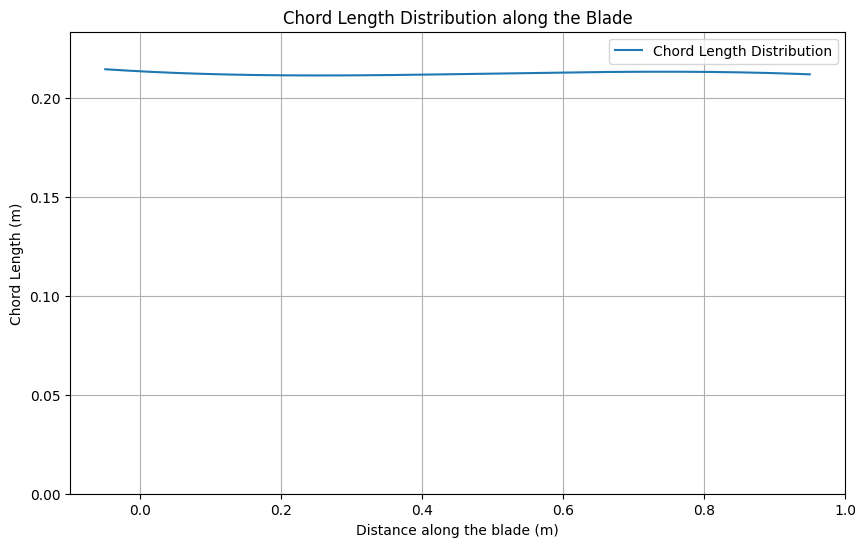

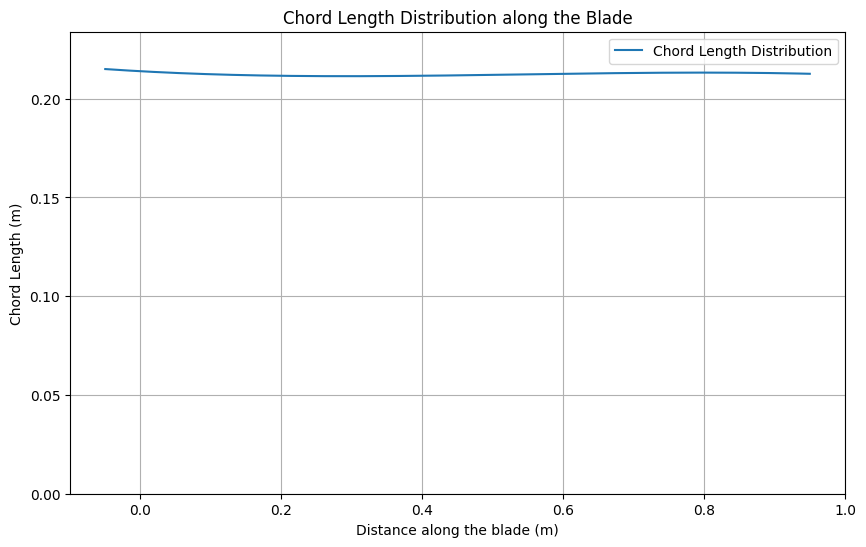

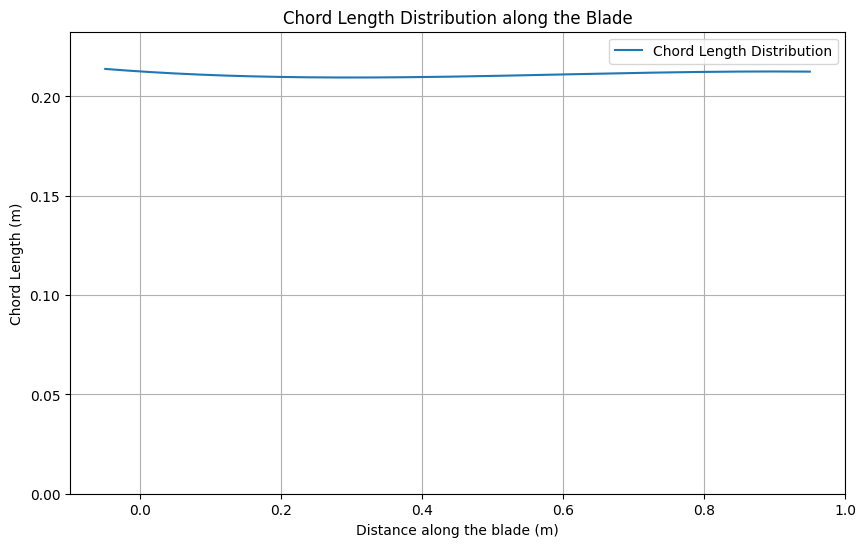

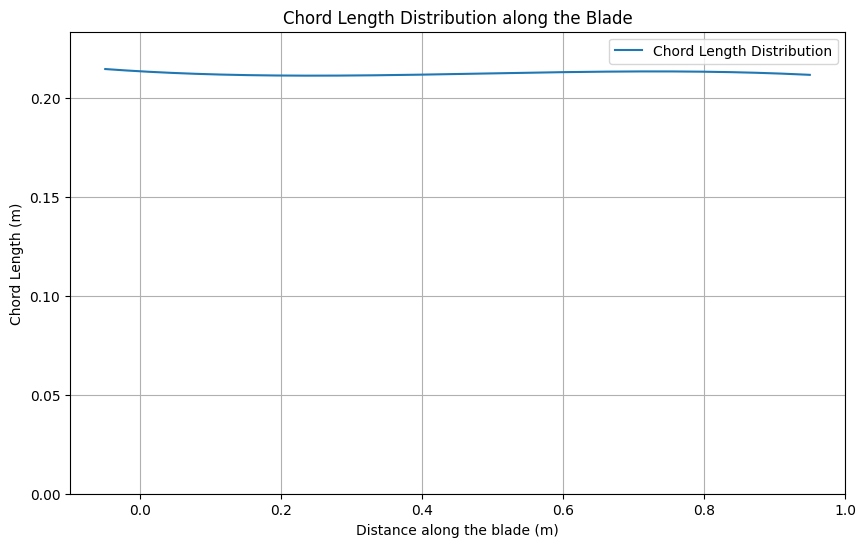

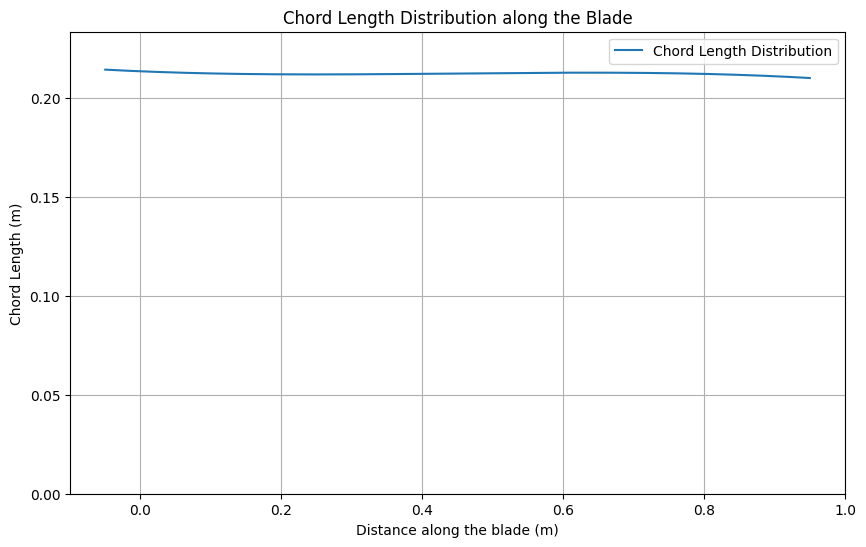

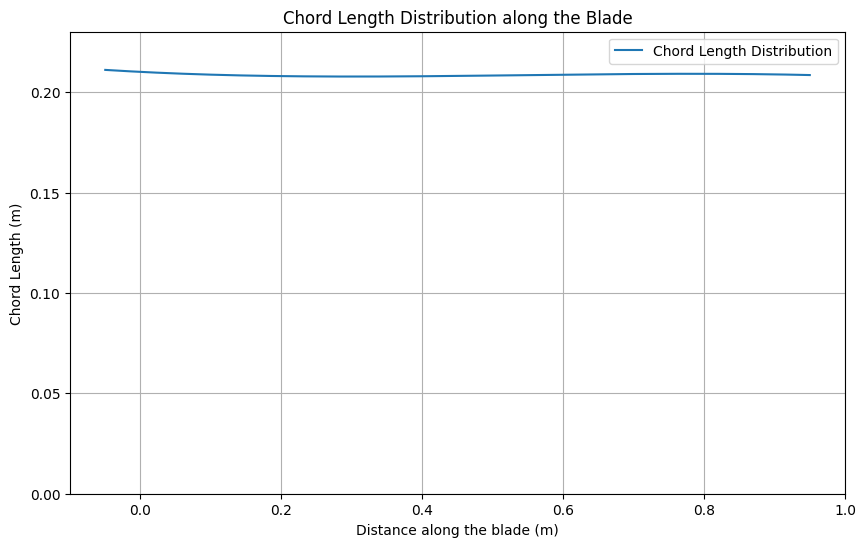

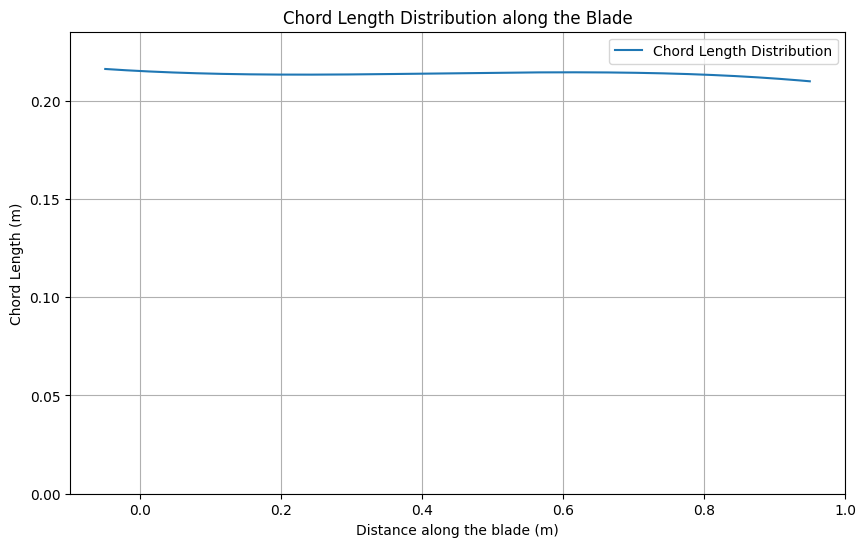

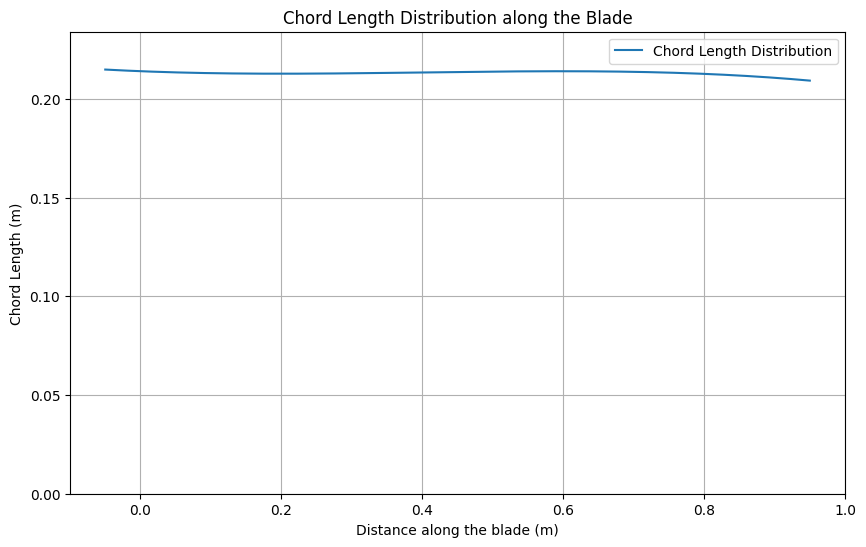

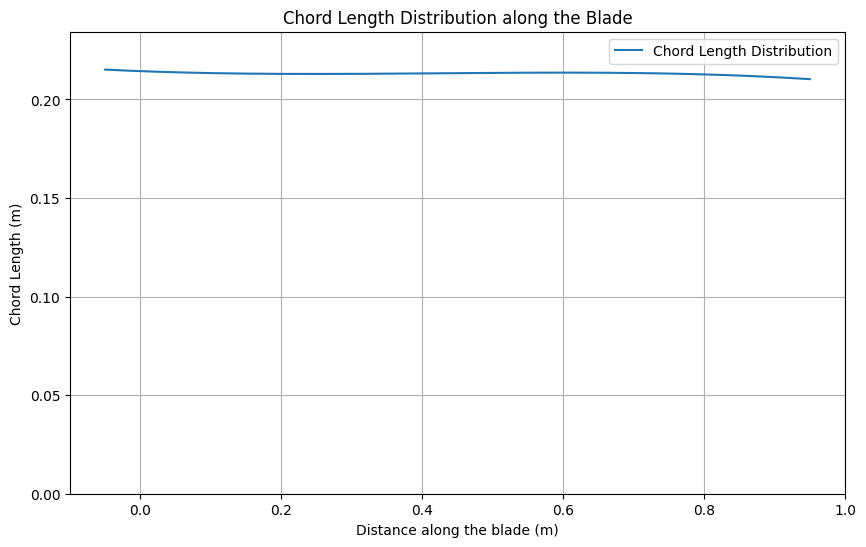

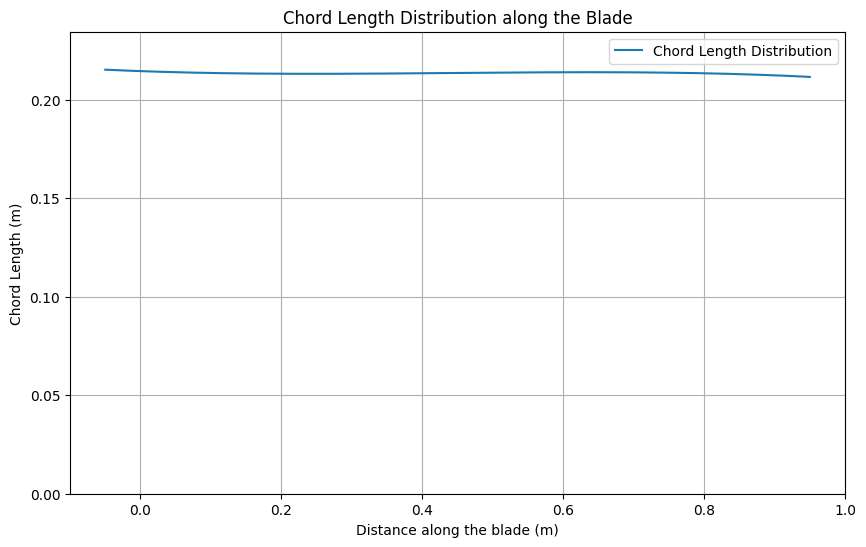

In [129]:

for i in range(mu):

    # Parameters
    c0 = parents[i][0]  # root chord length in meters
    a1 = parents[i][4]#0.85678802#0.976
    a2 = parents[i][5]#0.88#1.02
    a3 = parents[i][6]
    r_start = -0.05  # 5 cm prior to the root of the blade in meters
    # Function to compute chord length
    def chord_length(r, c0, a1, a2, a3, l_blade):
        return c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r / l_blade)**2 + (1 - a3) * (r / l_blade)**3))

    # Generate r values
    r_values = np.linspace(r_start, blade_length, 500)

    # Compute chord lengths
    chord_lengths = chord_length(r_values, c0, a1, a2, a3, blade_length)

    # Plot the chord length distribution
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, chord_lengths, label='Chord Length Distribution')
    plt.xlabel('Distance along the blade (m)')
    plt.ylabel('Chord Length (m)')
    plt.ylim(0, c0+0.02)
    plt.title('Chord Length Distribution along the Blade')
    plt.legend()
    plt.grid(True)
    plt.show()

# Tabu Search

start [0.15949601 5.70206926 2.07150891 5.34389385 0.49096595 1.
 1.        ] -0.7983561367460121
best_value -1.4429352974191576
best_value -1.46951485002183
best_value -1.5284067548379505
best_value -1.6336877021050937
best_value -1.7526455912334142
best_value -1.7905527799859238
best_value -1.7988469177800894
best_value -1.8003760588093978
best_value -1.8100133241884089
best_value -1.8196982374551214
best_value -1.8299926766707233
SI 0
intensify point [0.15949601 7.89879459 3.38954411 5.16115001 0.79096595 1.25605557
 0.84165467] value -1.6782608383259692
best_value -1.8338945373539963
best_value -1.839183046335228
best_value -1.8433167491057514
SI 1
intensify point [0.16858623 9.42794999 2.94350425 5.05092098 0.79096595 1.58349512
 0.56796361] value -1.8504792834241381
SD 0
SSR 0
best_value -1.8501465127501346
SI 2
intensify point [0.17212328 8.67269482 1.68209446 4.90290752 0.79096595 1.56958515
 0.58665082] value -1.850082148665007
best_value -1.855941836045105
SI 3
intensify poin

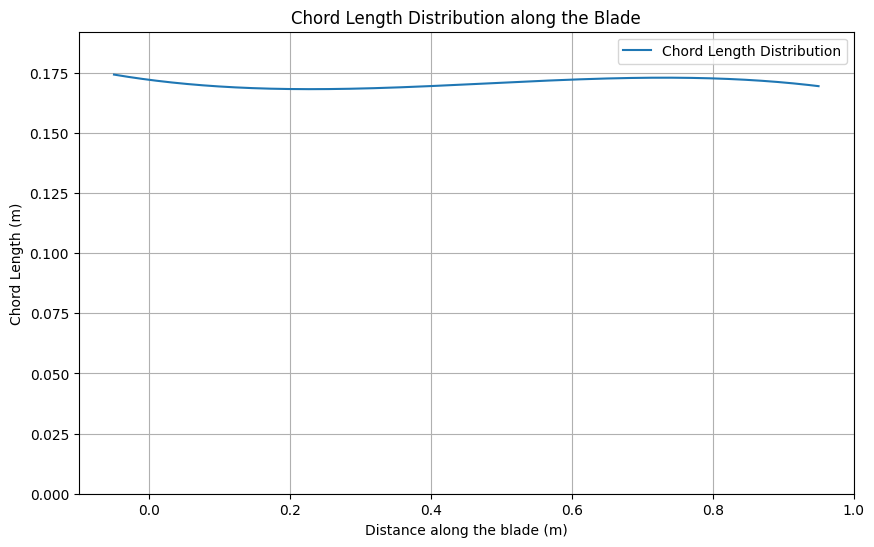

In [ ]:
import tabusearch_classes as ts_classes
import archive_module as am
import numpy as np

# -------------------- User Input --------------------------------

'''These are the only parameters the user should change'''
n = 7  # Dimensions
increment0 = 1  # Step size of search
beta = 0.75  # SSR factor
si = 10  # search intensification initiated
sd = 15 # 30  # search diversification initiated
ssr = 25#40 # step size reduction initiated
delta0 = increment0
min_increment = 1e-6
max_revisits = 10
penalty = 1
M = 4  # length MTM
T = 10  # length tabu list
D = 20  # number of random vectors generated

def f_A(x, aerofoil):
    global penalty
    return objective_function(x, aerofoil) + penalty * constraint_function(x)

# ------------------------------

def feasiblepoint(n):
    '''
    Determines a feasible point in n dimensions
    '''
    global countfevals

    while True:
        point = np.random.rand(n) * 10

        if constraint_function(point) == 0:
            countfevals += 1
            break
    return point

def check_distance(candidate, list, delta):
    """
    Checks that a candidate point is at least delta far away from all points in list

    returns True if it is and False if it isn't
    """
    result = all(np.linalg.norm(p[1] - candidate) > delta for p in list)
    return result

def random_unit_vector(n):
    """
    Generates a random unit vector in n dimensions.

    :param n: Dimension of the space.
    :return: A unit vector of length 1 in n-dimensional space.
    """
    # Generate a random vector with each component drawn from a normal distribution
    vector = np.random.randn(n)
    # Normalize the vector to make it a unit vector
    unit_vector = vector / np.linalg.norm(vector)
    return unit_vector

def localsearch(base_point, base_value, n, tabu):
    '''
    Search the neighborhood of the point and return the best point that is not tabu

    :param base_point: Base point to perform neighborhood search around.
    :param base_value: Objective function value of the base point
    '''
    global countfevals
    global increment
    global increment_direction

    neighborhood = []
    neighborhood_values = []
    orientation = [1, -1]
    for i in range(n):  # search axis
        for k in orientation:  # Orientation of axis
            increment_vector = np.zeros(n)
            increment_vector[i] = increment * k * increment_direction[i]
            search_point = base_point + increment_vector  # Search point axis[i] and orientation[k]

            if search_point not in tabu:  # Check if the move is allowed or tabu  
                neighborhood.append(search_point)
                neighborhood_values.append(f_A(search_point,aerofoil))
                countfevals += 1  

    if neighborhood:  # Check if neighborhood is not empty
        new_point, new_value = neighborhood[np.argmin(neighborhood_values)], np.min(neighborhood_values)  # Best allowed move
               
        if new_value < base_value:  # Check if the objective was reduced by move
            c = 0
            pattern_move = base_point + (new_point - base_point)  # Compute pattern move if true
            pattern_move_value = f_A(pattern_move, aerofoil)
            countfevals += 1
            if pattern_move_value < new_value:  # Check if pattern move reduced objective
                new_point, new_value = pattern_move, pattern_move_value  # assign new point 
        else: 
            c = 1
        
        return new_point, new_value, c
    else:        
        return None

# Memory
archive= am.Archive(size=25, D_min=0.3, D_sim=0.1)
sections = ts_classes.Sections()
tabu = ts_classes.TabuList(T)
ltm = ts_classes.LongTermMemory()
mtm = am.Archive(size=M, D_min=0.3, D_sim=0.1)
localminima = ts_classes.LocalMinima()

# Counter and lists
entry_count = 0
counter_best_locations = 0
counter_SI = 0
counter_SD = 0
counter_SSR = 0
countbreakout = 0
counter = 0
countfevals = 0
breakout_it_counter = 0
random_points_chosen = []
counter_empty_neighborhood = 0
local_minima = []
local_minima_rule = 0
intensification_list = [(5, 5)] 

best_locations = []
breakout_list = []

increment = increment0
increment_direction = np.array([0.02, 5, 3, 0.5, 0.3, 0.1, 0.05])
maxfevals = 10000
iteration = 0

# -------------------- Initiate Search --------------------------------
# Generate starting point
starting_point = generate_random_x(aerofoil)
point = starting_point.copy()
value = f_A(starting_point, aerofoil)
print('start', starting_point, value)
best_point = starting_point 
best_value = value
tabu.add(point)
mtm.add(point, value)

while countfevals <= maxfevals - 2 * n and iteration < 100:
    iteration += 1
    #print('iteration', iteration)
    # Test convergence
    if increment < min_increment:  # Terminates if the step size gets too small
        print('Step size too small, stopping search')
        break

    # LOCAL SEARCH: Search the points in the neighborhood
    local_search = localsearch(point, value, n, tabu)  # returns the new base point or none
    if local_search is not None:
        point, value, lm_rule = local_search  # new base point

        # Update memory
        localminima.conadd(point, lm_rule)
        mtm.add(point, value)  # Check that the point is far enough from the other points in the mtm to prevent singularity
        sections.conadd(point, delta0)  # Add to sections if at least delta0 away from all the points
        ltm.add(tuple(point))  # Update the long term memory
        tabu.add(point)  # Update the tabu list

        if localminima.found(lm_rule):  # reset counter if local minima was found
            counter = 0

    else:
        point = generate_random_x(aerofoil)  # No move was allowed, search is moved to random feasible point
        value = objective_function(point)
        countfevals += 1
    #print(point, value)
    #print(value)
    if value >= best_value:  # Check and update the best solution if the new solution is better
        counter += 1  # Local search didn't find a new minima, increment counter

        if counter == si:  # INTENSIFY: Move current search location to "average best" position
            print('SI', counter_SI)
            counter_SI += 1
            w = np.random.rand(mtm.coordinates().shape[0] )  # Random weights
            w = w / np.sum(w)  # sum has to be one
            x_k = w @ mtm.coordinates()  # random point within the space spanned by the mtm
            #breakoutvector = random_unit_vector(n)  # random breakout vector
            #point = x_k + increment * breakoutvector  # assign new point
            point = x_k
            value = f_A(point, aerofoil)
            print('intensify point', point, 'value', value)
            tabu.add(point)  # Update the tabu list
            ltm.add(tuple(point))  # Update the long term memory
            intensification_list.append(point)

        elif counter == sd:  # DIVERSIFICATION: Move current search location to unexplored region 
            print('SD', counter_SD)
            counter_SD += 1
            point = generate_random_x(aerofoil) 
            value = objective_function(point, aerofoil)
            countfevals += 1

        elif counter == ssr:  # STEP SIZE REDUCTION
            print('SSR', counter_SSR)
            counter_SSR += 1
            increment *= beta  # Reduce search increment 
            #print('INCREMENT', increment)
            point, value = best_point, best_value  # Assign new base point
            penalty = np.exp(1 + counter_SSR)  # update penalty
            counter = 0  

    else:  # Assign new best value and continue search
        best_point, best_value = point, value
        print('best_value', best_value)
        best_locations.append(best_point)
        counter_best_locations += 1
        counter = 0  # Set counter to zero and continue local search
    
    # -------------------- Archive --------------------------------
    candidate = (point, value)  # Coordinates and value of archive candidate
    archive.add(point, value)
print(best_point, best_value)
final_solution = (best_point, best_value)


# -------------------- Plotting final shape --------------------------------
# Parameters
c0 = best_point[0]  # root chord length in meters
a1 = best_point[4]#0.85678802#0.976
a2 = best_point[5]#0.88#1.02
a3 = best_point[6]
r_start = -0.05  # 5 cm prior to the root of the blade in meters
# Function to compute chord length
def chord_length(r, c0, a1, a2, a3, l_blade):
    return c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r / l_blade)**2 + (1 - a3) * (r / l_blade)**3))

# Generate r values
r_values = np.linspace(r_start, blade_length, 500)

# Compute chord lengths
chord_lengths = chord_length(r_values, c0, a1, a2, a3, blade_length)

# Plot the chord length distribution
plt.figure(figsize=(10, 6))
plt.plot(r_values, chord_lengths, label='Chord Length Distribution')
plt.xlabel('Distance along the blade (m)')
plt.ylabel('Chord Length (m)')
plt.ylim(0, c0+0.02)
plt.title('Chord Length Distribution along the Blade')
plt.legend()
plt.grid(True)
plt.show()

[ 0.23488011 33.84870119 33.42952913  4.64703296  1.00090057  0.93261719
  1.        ] -0.3523994118137746

In [ ]:
def BEM(x, CLs=CLs, CDs=CDs, n_blades=3, u0=1.5, tip_constraint=0.95, rhub=0.1, r_total=1, n=10):
    """ BEM method for the entire blade 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    # Constants
    relax = 1.0
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    #c = c0 * (1 - (1 - taper) * r / l_blade) # length of each cord element stored in array
    c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
    #print('c', c)
    twirl = twirl0 - (r - rhub) / l_blade * twist # twirl of each cord element stored in array
    #print('twirl', twirl)
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    n_it = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        print('Element ',i)
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 50: 
                print('Counter reached 50')
                if u > u0: # check if 
                    Ct[i] = 0
                    Cn[i] = 0
                break
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            if i ==0:
                print(u)
            #print('wind speed at element', u)
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            alpha = np.degrees(phi) - twirl[i] # local angle of attack in degrees
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = lift_interpolator(checked_values) # lift coefficeint
            Cd = drag_interpolator(checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    if u >= u0:
                        #print('Wind speed unrealsitic')
                        Ct[i] = 0
                        Cn[i] = 0
                        break
                    else:
                        break
            counter += 1
        print(counter)
        # print('Cl', Cl, 'CD', Cd)
        # print('Ct', Ct[i], 'Cn', Cn[i])
        # print('Re', Re)
        # print('Attack angle', alpha)
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*r*dr
    if np.any(dQ < 0):
        dQ = np.zeros(n)
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, thrust)

NameError: name 'CLs' is not defined

In [ ]:
def constraint_function(x, cmin=cmin, c0min=c0min, c0max=c0max, twistmin=twistmin, tsrmin=tsrmin, tsrmax=tsrmax, twirl0max=twirl0max, twirl0min=twirl0min):
    c0, twirl0, twist, tsr, a1, a2, a3 = x
    c1 = max(0, c0min - c0)
    c2 = max(0, c0 - c0max)
    # c3 = max(0,  tapermin(c0, cmin) - taper)
    # c4 = max(0,  taper - 1)
    c3 = max(0, cmin - taper_function(blade_length, c0, a1, a2, a3, blade_length))
    c4 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - c0)
    c11 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - taper_function(blade_length/2, c0, a1, a2, a3, blade_length))
    c12 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - taper_function(blade_length/3, c0, a1, a2, a3, blade_length))
    c13 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - taper_function(blade_length*2/3, c0, a1, a2, a3, blade_length))
    c14 = max(0, taper_function(0.6*blade_length, c0, a1, a2, a3, blade_length) - c0)
    c5 = max(0, tsrmin - tsr)
    c6 = max(0, tsr - tsrmax)
    c7 = max(0, twistmin - twist)
    c8 = max(0, twist - twirl0)
    c9 = max(0, twirl0min - twirl0)
    c10 = max(0, twirl0 - twirl0max)
    
    # List of constraints
    constraints = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14]

    # Print each constraint
    for i, c in enumerate(constraints, start=1):
        print(f"c{i}: {c}")
    
    return c1 + c2 +  (c3 + c4 + c11 + c12 + c13 + c14) + c5 + c6 + c7 + c8 + c9 + c10

In [ ]:
x = best_parent
print(objective_function(x))

Element  0
1.5
1.0941229401228358
1.0788581042974192
0.9565887142712394
0.9298604785720183
1.037938182098133
1.1127267146443047
1.0211361170603293
1.1532152546761036
0.9548951553122764
0.9356911789014729
0.9863999298177782
1.1398136053456
0.9551903073951357
0.9270480225005323
1.0321262634806971
1.098893367199958
1.1877372752429105
0.9545856279018402
0.9372427850023111
0.9736059619672343
1.0764044361643883
1.0607253659042941
1.0118464954197512
1.0629490232129606
1.1710458124408176
0.9548307102256899
0.9319896304389331
1.0247329898858288
1.0926943655361057
1.1273885274655169
1.0058701834236423
0.9710189463215542
1.0806244080240264
1.1035776052546777
1.2887063010024968
1.0153785201303698
0.9286726473050555
0.9850497717638151
1.13641499503181
0.9547646135482706
0.9258679383512343
1.0295330223275985
1.0928559343591808
1.2294044229129386
0.9814797326883495
0.932296000457921
0.9877734224384359
1.1261543427022405
0.9770286113598963
Counter reached 50
50
Element  1
3
Element  2
Counter reached 